In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as mx

from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression # for Lasso and Elastic Net logistic regression
from sklearn.cross_decomposition import PLSRegression

# In this tutorial we will implement PLS, ridge, lasso and elastic net regression models

## Learning Outcomes: 
1) Implement PLS, ridge, and lasso and elastic-net using the popular python library sklearn https://scikit-learn.org/stable/
2) Visualise the regression results 
3) Explore different metrics to evaluate the model performance in regression settings
4) Investigate the effect of scaling the data on the model performance
5) Apply peanilised (ligistic) regression for classification 

## Data

In this tuorial we will use some plasma metabolomics data to predict BMI

In [2]:
df = pd.read_csv('Data/diabetes_metabolomics_plasma.csv') #import the data 

In [3]:
df.head() ### 

,AGE,GENDER,BMI,ETH,T2D,sample_id,"1,11-Undecanedicarboxylic acid","1,2-dipalmitoylglycerol","1,2-propanediol","1,3,7-trimethylurate",...,tyrosine,undecanoate (11:0),urate,urea,uridine,valine,xanthine,xylitol,xylonate,xylose
0,35,0,25.0,2,0,QMDiab-ID222,4.015998,4.822787,5.098491,4.430118,...,6.844272,4.885885,5.824023,7.577408,5.290736,7.239540,4.254777,4.052859,4.387091,4.676128
1,47,1,28.4,3,0,QMDiab-ID113,4.165116,4.991613,5.064084,4.585177,...,6.755005,4.777224,5.990350,7.465627,5.220019,7.348071,4.183861,4.341484,4.460427,4.585401
2,55,1,29.7,1,0,QMDiab-ID29,3.928917,4.965361,5.185007,4.006547,...,6.971284,4.737634,5.892525,7.433326,5.188568,7.356957,4.350213,4.101610,4.726884,4.785554
3,56,1,23.1,2,0,QMDiab-ID243,4.272476,4.819821,5.015473,4.564346,...,6.943175,4.736576,5.832160,7.422004,5.037060,7.260422,4.037787,4.111296,4.488342,4.696762
4,36,1,30.1,1,0,QMDiab-ID270,3.914247,4.900546,5.264884,3.719528,...,7.068370,4.754971,6.013982,7.786201,5.388167,7.377851,4.211793,4.099279,4.545646,4.630343


As you can see this data set in its current format is not suitable for our alogirthms. 
In python column indices start from 0, we want to subset only the metabolomics colulmns for feature scaling. 


In [4]:
# Create feature matrix and target vector
X = df.iloc[:,6:]
y = df['BMI']

In [5]:
X.head() # Try using the .tail() function -- it is similar to the .head() function but displays the last 5 rows 

,"1,11-Undecanedicarboxylic acid","1,2-dipalmitoylglycerol","1,2-propanediol","1,3,7-trimethylurate","1,3-dihydroxyacetone","1,3-dipalmitoylglycerol","1,5-anhydroglucitol (1,5-AG)","1,7-dimethylurate",1-arachidonoylglycerophosphocholine*,1-arachidonoylglycerophosphoethanolamine*,...,tyrosine,undecanoate (11:0),urate,urea,uridine,valine,xanthine,xylitol,xylonate,xylose
0,4.015998,4.822787,5.098491,4.430118,5.099892,3.931847,5.635887,4.383338,6.419791,5.494844,...,6.844272,4.885885,5.824023,7.577408,5.290736,7.239540,4.254777,4.052859,4.387091,4.676128
1,4.165116,4.991613,5.064084,4.585177,4.914487,4.547639,5.628356,4.205478,6.376636,5.521565,...,6.755005,4.777224,5.990350,7.465627,5.220019,7.348071,4.183861,4.341484,4.460427,4.585401
2,3.928917,4.965361,5.185007,4.006547,5.199614,4.715108,5.532230,4.068107,6.398308,5.512725,...,6.971284,4.737634,5.892525,7.433326,5.188568,7.356957,4.350213,4.101610,4.726884,4.785554
3,4.272476,4.819821,5.015473,4.564346,5.123898,4.328667,5.245998,4.448552,6.383578,5.573093,...,6.943175,4.736576,5.832160,7.422004,5.037060,7.260422,4.037787,4.111296,4.488342,4.696762
4,3.914247,4.900546,5.264884,3.719528,4.997426,4.408874,5.907860,4.078259,6.397295,5.613761,...,7.068370,4.754971,6.013982,7.786201,5.388167,7.377851,4.211793,4.099279,4.545646,4.630343


In order to test our alogrithms we need to set aside some of the data we have. This is practice for machine learning models. We will use 80% of our data to train our model, and the remaining 20% will be used to test the performance of our model. 

Scikit-Learn has a function train_test_split to easily do this for us.

In [6]:
# Import train-test split
from sklearn.model_selection import train_test_split

# Split the df into 80% train 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=42) #### if you want you can change the number '42 to your birthday and it will change the results slightly'

It is crucial that all of the data it is comparing is on the same scale. In our metabolomics data, most of the data is continuous. We will scale the data using the StandardScaler() shown in the previous tutorials. 

When scaling your data you want to fit the model to your training data, and only transform your testing data. 

In [7]:
# Normalize Data
from sklearn.preprocessing import StandardScaler

# Instantiate scaler model
scaler = StandardScaler()

# Fit and Transform X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform X_test
X_test_scaled = scaler.transform(X_test)

### PLS Regression 

In [8]:
pls2 = PLSRegression(n_components=1)
pls2.fit(X_train_scaled, y_train)
y_pred = pls2.predict(X_test_scaled)

#### Metrics
Today we will use the follwing metrics
- explained_variance_score
- r2_score
- mean_squared_error
- mean_absolute_error
- SMAPE (Symmetric mean absolute percentage error)

In [9]:
# This is just a helper function to get the smap metric - no need to change 
def smape(A, F):
    out =  100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return(out)

In [10]:
## Here we will defeine several helper functions to compute these metrics 
from sklearn import metrics
def RegmodelPerformance(y_true, y_pred):
    exp_var = metrics.explained_variance_score(y_true, y_pred)
    r_square = metrics.r2_score(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    SMAPE = smape(np.array(y_true), y_pred)
    return(exp_var, r_square, MSE, MAE, SMAPE)

def printPerformance(y_true, y_pred):
    exp_var, r_square, MSE, MAE, SMAPE = RegmodelPerformance(y_true, y_pred)
    print("explained variance score = " "%.4f" % exp_var)
    print("R2 = " "%.4f" % r_square)
    print("MSE = " "%.4f" % MSE)
    print("MAE = " "%.4f" % MAE)
    print("SMAPE = " "%.4f" % SMAPE)
    np.set_printoptions(precision=2)

In [11]:
printPerformance(y_test, y_pred)

explained variance score = 0.2406
R2 = 0.2400
MSE = 43.6275
MAE = 4.8749
SMAPE = 1376.0287


Whilst we have trained and fit a PLS model, we have not optimised the number of components. We also have not done any cross validation.

Text(0.5, 1.0, 'Cross-validation Metrics')

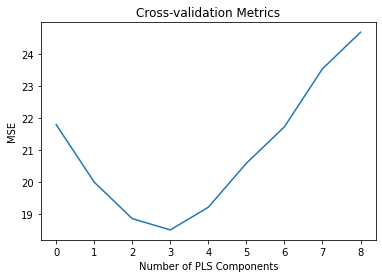

In [12]:
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.preprocessing import scale 
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=123)

mse = []
n = len(X_train)



# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 10):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X_train), y_train, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('Cross-validation Metrics')


Alternatively, we can also run our own 10-fold CV.

Try below to fill in with your own code to the cross-validation loop

In [13]:
exp_vars = []
r_squares = []
MSEs = []
MAEs = []
SMAPEs = [] 
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, random_state=42, shuffle=False)
kf.get_n_splits(X_train_scaled)
for train_index, test_index in kf.split(X_train):
    
''' add your own code here then investigate what I wrote below'''''

IndentationError: expected an indented block (<ipython-input-13-adc7504c0738>, line 11)

In [14]:
# Calculate MSE using cross-validation, 
exp_var_mean = 0 
r_square_mean = 0
MSE_mean = 0 
MAE_mean = 0
SMAPE_mean = 0 
kf = KFold(n_splits=10, random_state=None, shuffle=False)
kf.get_n_splits(X_train)

for train_index, val_index in kf.split(X_train):
    X_traincv = X_train.iloc[train_index]
    X_valcv = X_train.iloc[val_index]
    y_traincv = y_train.iloc[train_index]
    y_valcv = y_train.iloc[val_index]
    X_traincv = scaler.fit_transform(X_traincv)
    X_valcv = scaler.fit_transform(X_valcv)
    pls = PLSRegression(n_components=2) ## i is the no. components, consider 
    pls.fit(X_traincv, y_traincv)
    ypred = pls.predict(X_valcv)
    exp_var, r_square, MSE, MAE, SMAPE = RegmodelPerformance(y_valcv, ypred)
    exp_var_mean+= exp_var
    r_square_mean += r_square
    MSE_mean += MSE
    MAE_mean += MAE
    SMAPE_mean += SMAPE
    
    

In [15]:
## in the space below compute the mean and standard deviations of your metrics
## I have done the first one as an exaemple

print(exp_var_mean/10)
print(r_square_mean/10)

0.30927409926114213
0.28691237018318405


Now have a think how you might do this and optimise the number of components at the same time

In [16]:
exp_vars = []
r_squares = []
MSEs = []
MAEs = []
SMAPEs = [] 
# Calculate MSE using cross-validation, adding one component at a time
for i in range(1, 12):   #Here we are defining how many components 
    exp_var_mean = 0 
    r_square_mean = 0
    MSE_mean = 0 
    MAE_mean = 0
    SMAPE_mean = 0 
    kf = KFold(n_splits=10, random_state=None, shuffle=False) ## can also input and value you like for random state but also set shuffle = Ture
    kf.get_n_splits(X_train)

    for train_index, val_index in kf.split(X_train):
        X_traincv = X_train.iloc[train_index]
        X_valcv = X_train.iloc[val_index]
        y_traincv = y_train.iloc[train_index]
        y_valcv = y_train.iloc[val_index]
        X_traincv = scaler.fit_transform(X_traincv)
        X_valcv = scaler.fit_transform(X_valcv)
        pls = PLSRegression(n_components=i) ## i is the no. components
        pls.fit(X_traincv, y_traincv)
        ypred = pls.predict(X_valcv)
        exp_var, r_square, MSE, MAE, SMAPE = RegmodelPerformance(y_valcv, ypred)
        exp_var_mean+= exp_var
        r_square_mean += r_square
        MSE_mean += MSE
        MAE_mean += MAE
        SMAPE_mean += SMAPE
    exp_vars.append(exp_var_mean/10)
    r_squares.append(r_square_mean/10)
    MSEs.append(MSE_mean/10)
    MAEs.append(MAE_mean/10)
    SMAPEs.append(SMAPE_mean/10)

In [17]:
len(MSEs) ## printing len MSE should be the same as however many components you have looked into 

11

Text(0.5, 1.0, 'Cross-validation Metrics')

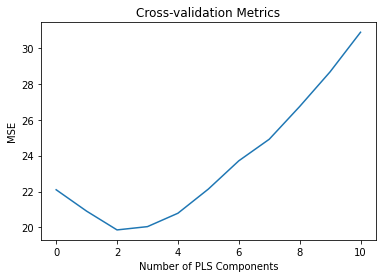

In [18]:
#plot test MSE vs. number of components
plt.plot(MSEs)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('Cross-validation Metrics')


Results vary slightly depending on the split seed values, although it looks like the best model is the one with 3 components

In [19]:
pls2 = PLSRegression(n_components=3)
pls2.fit(X_train_scaled, y_train)
y_pred = pls2.predict(X_test_scaled)
printPerformance(y_test, y_pred)

explained variance score = 0.3879
R2 = 0.3877
MSE = 35.1528
MAE = 4.3807
SMAPE = 1486.4926


## LASSO 

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [21]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('MAE: %.3f' % (results.best_score_*-1))
print('Config: %s' % results.best_params_)

MAE: 3.452
Config: {'alpha': 0.21}


In [22]:
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)

explained variance score = 0.4348
R2 = 0.4328
MSE = 32.5611
MAE = 4.1788
SMAPE = 13.3090


### Ridge 

Try right the above but using the Ridge() function. Click the three dots in the cell below will expand to show the result

In [23]:
# define model and try the rest yourself
model = Ridge()

In [24]:
# define model
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('MAE: %.3f' % (results.best_score_*-1))
print('Config: %s' % results.best_params_)

MAE: 5.531
Config: {'alpha': 0.99}


In [25]:
# test set performane 
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)

explained variance score = -0.1190
R2 = -0.1217
MSE = 64.3957
MAE = 5.9618
SMAPE = 19.6583


### Elastic-Net 

Elastic Net is a mix of both ridge and lasso, where we can tune both of the parameters.

Don't worry if the below code returns some warnings around the model not convering. However, do think about what this means

In [26]:
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# define grid
grid = dict()
grid = {"max_iter": [10, 50, 100],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('MAE: %.3f' % (results.best_score_*-1))
print('Config: %s' % results.best_params_)

MAE: 3.340
Config: {'alpha': 1, 'l1_ratio': 0.0, 'max_iter': 50}


/home/kl2418/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+03, tolerance: 8.569e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [27]:
# test set performane 
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)

explained variance score = 0.3887
R2 = 0.3887
MSE = 35.0953
MAE = 4.3329
SMAPE = 13.8151


### What's Next?
We have walked through how to implement PLS, Ridge, LASO, Elastic_Net regressioj
For further understanding and practice:
- Try using a different scaling for instance: robust_scale / RobustScaler, power_transform / PowerTransformer
- Change certain paramaters like number of folds, ncomponents (PLS), alpha and lambda values, e.g try a larger grid search 
- Use a different dataset for a regression problem
- Implement different error metrics for regression
- Implement the classification versions of these, look at examples here https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
